In [1]:
from sotip import *
import numpy as np
import scanpy as sc


In [2]:
adata = sc.read_h5ad('p16_20211130.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 1023 × 36
    obs: 'row_num', 'point', 'cell_id', 'X1', 'center_rowcoord', 'center_colcoord', 'cell_size', 'category', 'donor', 'Cluster', 'leiden', 'ME_heter_Cluster_uniform', 'ME_heter_Cluster_paga_guided_umap', 'Cluster_knn', 'leiden_EMD', 'leiden_EMD_merge'
    uns: 'Cluster_colors', 'Cluster_knn_colors', 'Cluster_sizes', 'GD', 'MEidx', 'leiden', 'leiden_EMD_colors', 'leiden_EMD_merge_colors', 'leiden_EMD_merge_sizes', 'leiden_EMD_sizes', 'leiden_colors', 'merge_cls_list', 'neighbors', 'neighbors_EMD', 'paga', 'point_colors', 'umap'
    obsm: 'ME', 'X_umap', 'X_umap_EMD', 'dummy_X', 'spatial'
    obsp: 'connectivities', 'distances'

In [70]:
adata.uns['leiden_EMD_merge_colors'] = ['r','k']

In [71]:
rename_dict = {
    '7':'immune',
    '9':'tumor'
}
adata.obs['leiden_EMD_merge'] = adata.obs['leiden_EMD_merge'].cat.rename_categories(rename_dict)

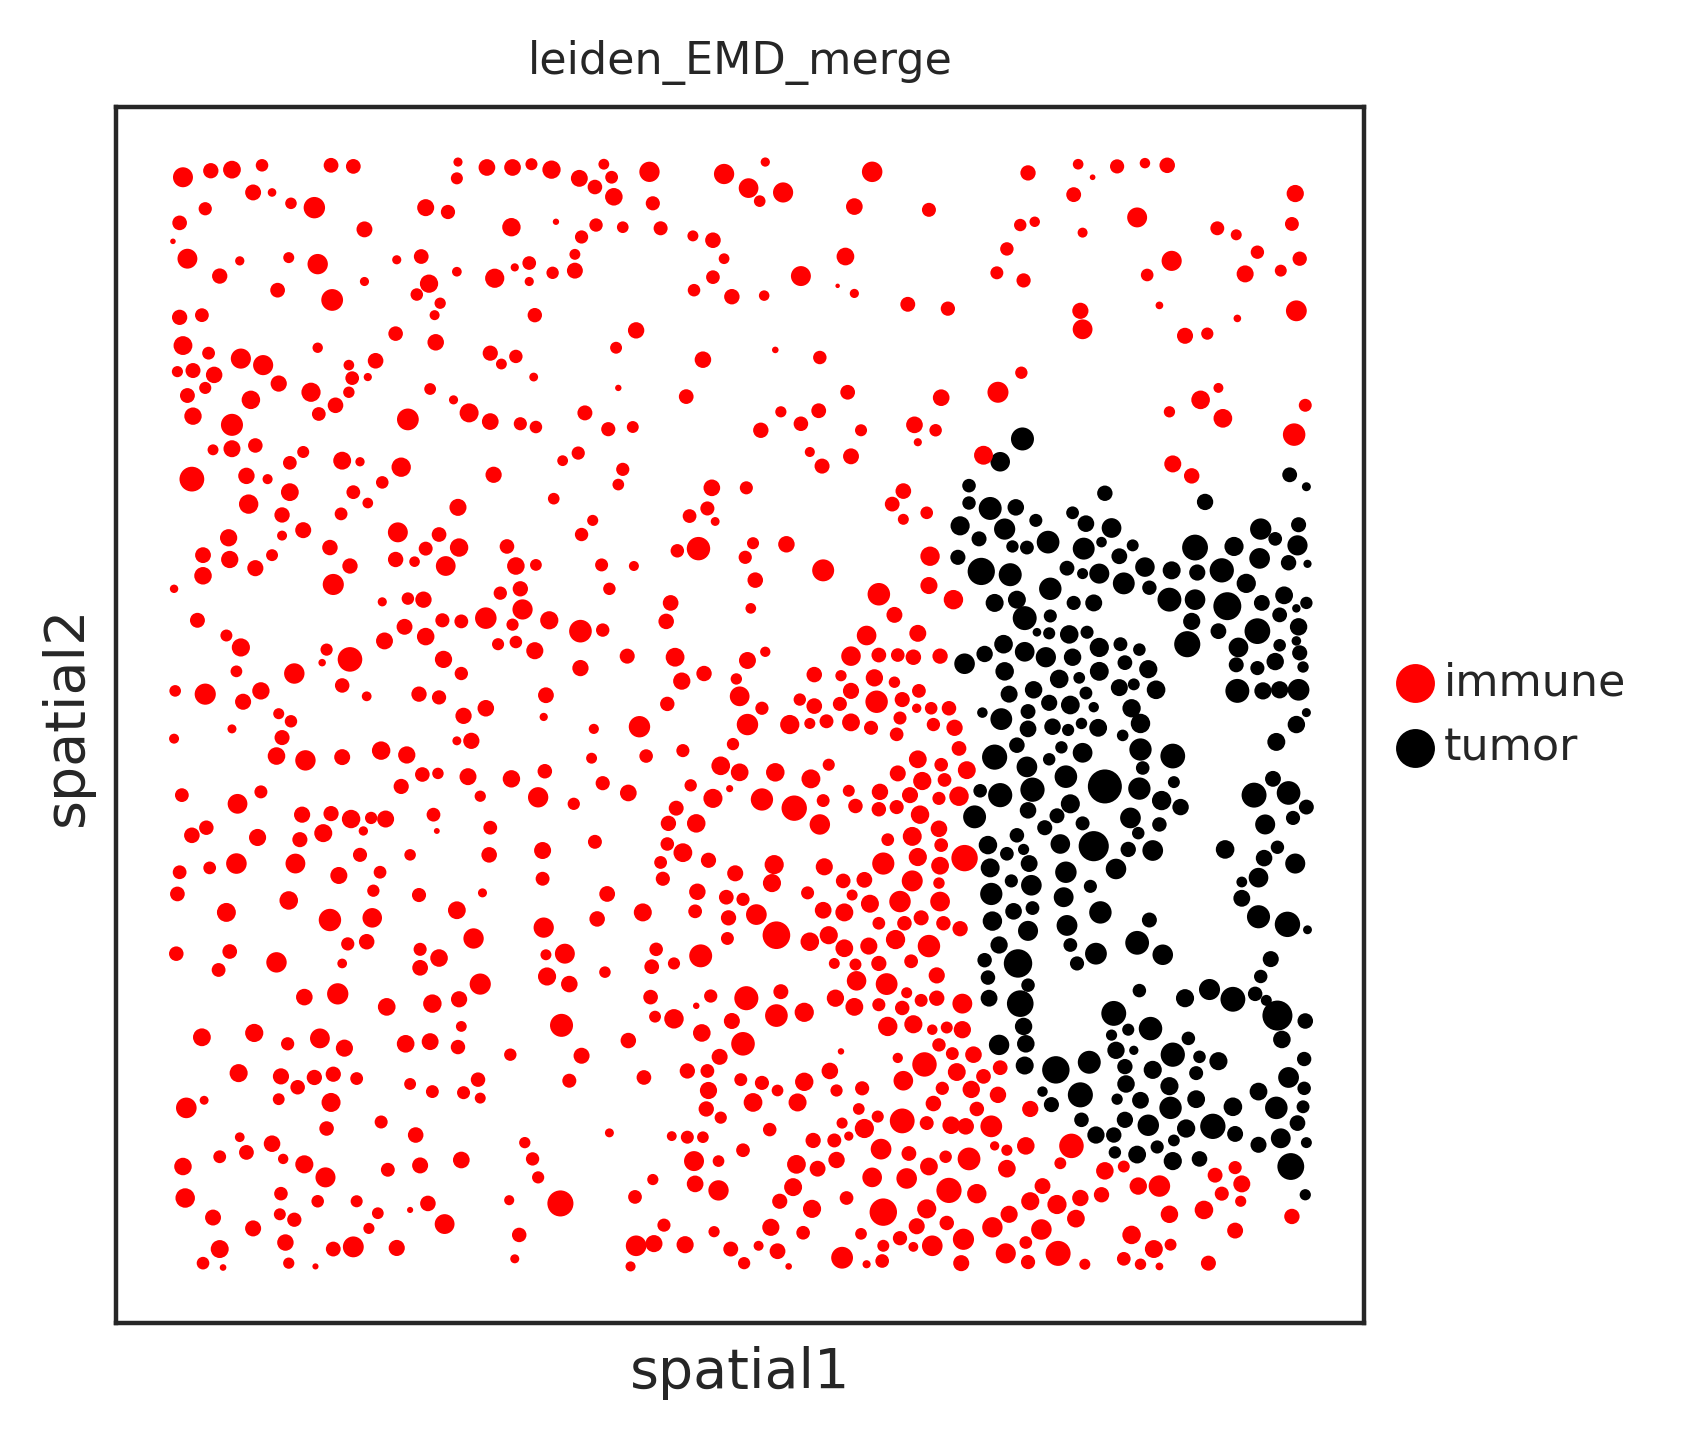

In [72]:
sc.pl.embedding(adata,basis='spatial',color=['leiden_EMD_merge'],size=adata.obs['cell_size']/10)

In [9]:
# min distance
spatial_mat = adata.obsm['spatial']
dist_mat = squareform(pdist(spatial_mat))

In [14]:
for region in adata.obs['leiden_EMD_merge'].cat.categories:
    cur_idx = np.where(adata.obs['leiden_EMD_merge']==region)[0]
    cur_dist_obs = f'min_dist_to_{region}'
    cur_min_dist = np.min(dist_mat[:,cur_idx],axis=1)
    adata.obs[cur_dist_obs] = cur_min_dist

In [15]:
adata

AnnData object with n_obs × n_vars = 1023 × 36
    obs: 'row_num', 'point', 'cell_id', 'X1', 'center_rowcoord', 'center_colcoord', 'cell_size', 'category', 'donor', 'Cluster', 'leiden', 'ME_heter_Cluster_uniform', 'ME_heter_Cluster_paga_guided_umap', 'Cluster_knn', 'leiden_EMD', 'leiden_EMD_merge', 'min_dist_to_immune', 'min_dist_to_tumor'
    uns: 'Cluster_colors', 'Cluster_knn_colors', 'Cluster_sizes', 'GD', 'MEidx', 'leiden', 'leiden_EMD_colors', 'leiden_EMD_merge_colors', 'leiden_EMD_merge_sizes', 'leiden_EMD_sizes', 'leiden_colors', 'merge_cls_list', 'neighbors', 'neighbors_EMD', 'paga', 'point_colors', 'umap'
    obsm: 'ME', 'X_umap', 'X_umap_EMD', 'dummy_X', 'spatial'
    obsp: 'connectivities', 'distances'

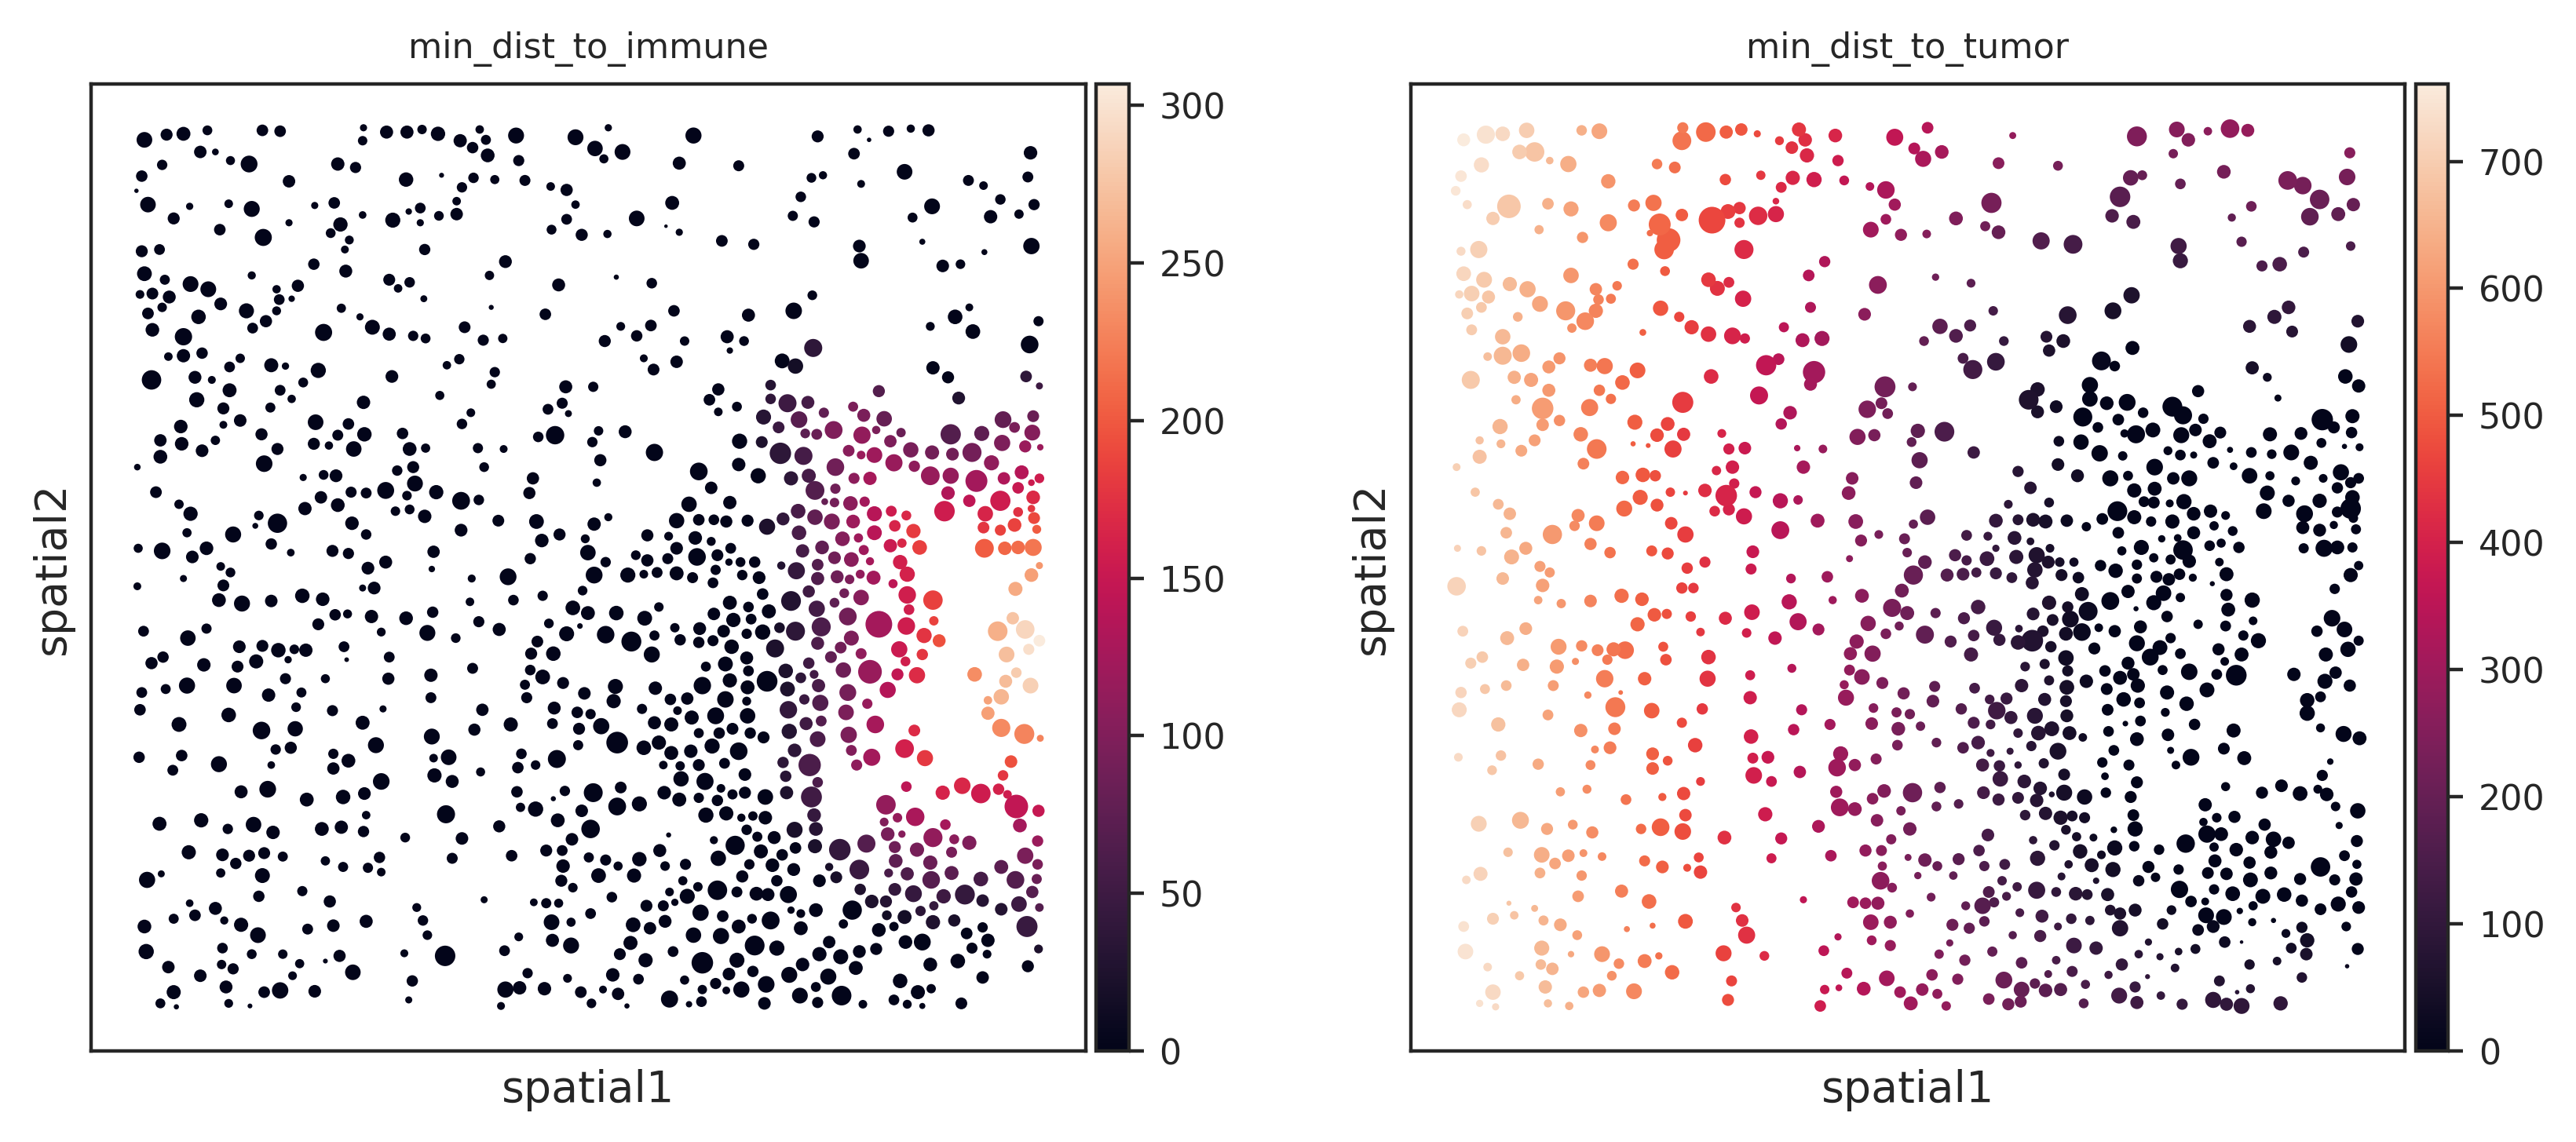

In [17]:
sc.pl.embedding(adata,basis='spatial',color=['min_dist_to_immune','min_dist_to_tumor'],size=adata.obs['cell_size']/10)

# polarized proteins to tumor

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [18]:
adata_immune = adata[adata.obs['leiden_EMD_merge']=='immune']

In [21]:
adata_immune

View of AnnData object with n_obs × n_vars = 758 × 36
    obs: 'row_num', 'point', 'cell_id', 'X1', 'center_rowcoord', 'center_colcoord', 'cell_size', 'category', 'donor', 'Cluster', 'leiden', 'ME_heter_Cluster_uniform', 'ME_heter_Cluster_paga_guided_umap', 'Cluster_knn', 'leiden_EMD', 'leiden_EMD_merge', 'min_dist_to_immune', 'min_dist_to_tumor'
    uns: 'Cluster_colors', 'Cluster_knn_colors', 'Cluster_sizes', 'GD', 'MEidx', 'leiden', 'leiden_EMD_colors', 'leiden_EMD_merge_colors', 'leiden_EMD_merge_sizes', 'leiden_EMD_sizes', 'merge_cls_list', 'neighbors', 'neighbors_EMD', 'paga', 'point_colors', 'umap'
    obsm: 'ME', 'X_umap', 'X_umap_EMD', 'dummy_X', 'spatial'
    obsp: 'connectivities', 'distances'

In [24]:
rf_X = np.array(adata_immune.X)
rf_Y = np.array(adata_immune.obs['min_dist_to_tumor'])

### spearman 

In [52]:
adata.var_names

Index(['H3', 'vimentin', 'SMA', 'CD98', 'NRF2p', 'CD4', 'CD14', 'CD45', 'PD1',
       'CD31', 'SDHA', 'Ki67', 'CS', 'S6p', 'CD11c', 'CD68', 'CD36', 'ATP5A',
       'CD3', 'CD39', 'VDAC1', 'G6PD', 'XBP1', 'PKM2', 'ASCT2', 'GLUT1', 'CD8',
       'CD57', 'LDHA', 'IDH2', 'HK1', 'Ecad', 'CPT1A', 'CK', 'NaKATPase',
       'HIF1A'],
      dtype='object')

In [ ]:
protein

In [63]:
var_spearman_cor = np.zeros(shape=(adata_immune.shape[1]))
var_spearman_pv = np.zeros(shape=(adata_immune.shape[1]))

for i in range(adata_immune.var_names.shape[0]):
    protein = adata_immune.var_names[i]
    cur_protein_array = adata_immune[:,protein].X
    cur_spearmanr = spearmanr(cur_protein_array,rf_Y)
    # adata_immune.var['spearman_cor'] = cur_spearmanr[0]
    # adata_immune.var['spearman_pv'] = cur_spearmanr[1]   
    var_spearman_cor[i] = cur_spearmanr[0]
    var_spearman_pv[i] = cur_spearmanr[1]
adata_immune.var['spearman_cor'] = var_spearman_cor
adata_immune.var['spearman_pv'] = var_spearman_pv

    

In [64]:
protein_order_pd = adata_immune.var.sort_values(by='spearman_cor',ascending=True)

In [65]:
protein_show = np.array(protein_order_pd.iloc[:50].index)

title = [f'{p} {protein_order_pd.loc[p].values}' for p in protein_show]


In [ ]:
protein_show = np.array(protein_order_pd.iloc[:50].index)

title = [f'{p} {protein_order_pd.loc[p].values[1:]}' for p in protein_show]

sc.pl.embedding(adata_immune,basis='spatial',
                color=protein_show,
                ncols=2,title=title)

# compare detected polarized proteins with gt

In [89]:
gt_polarized = ['CD98','XBP1','LDHA','VDAC1','G6PD','PKM2','CS','GLUT1','ASCT2','SDHA','CPT1A','CD11c']

In [90]:
sotip_polarized = protein_order_pd[(protein_order_pd.spearman_cor<0) & (protein_order_pd.spearman_pv<=0.05)].index

In [112]:
for i in gt_polarized:
    print(i)

CD98
XBP1
LDHA
VDAC1
G6PD
PKM2
CS
GLUT1
ASCT2
SDHA
CPT1A
CD11c


In [113]:
for i in sotip_polarized:
    print(i)

LDHA
CD98
CD4
CD3
PKM2
CD11c
CD45
HK1
Ecad
GLUT1
CD8
NRF2p
Ki67
vimentin
CD39
CS
CD31
CK
PD1
NaKATPase
CPT1A
CD14
CD57
IDH2
ATP5A


In [114]:
for i in adata.var_names:
    print(i)

H3
vimentin
SMA
CD98
NRF2p
CD4
CD14
CD45
PD1
CD31
SDHA
Ki67
CS
S6p
CD11c
CD68
CD36
ATP5A
CD3
CD39
VDAC1
G6PD
XBP1
PKM2
ASCT2
GLUT1
CD8
CD57
LDHA
IDH2
HK1
Ecad
CPT1A
CK
NaKATPase
HIF1A


In [111]:
protein_order_pd.to_csv('sotip_polarization_test.csv')